[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Carioca_Wave.ipynb)

In [ ]:
!pip install JaxSSO
!pip install PyNiteFEA
!pip install nlopt

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, grad,jit,vmap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import PyNite as pyn #FEA solver
import JaxSSO as sso #Sensitivity analysis solver
from functools import partial
import pandas as pd

# Initial geometry and mesh of Carioca Wave

In [ ]:
path_2_file = 'https://github.com/GaoyuanWu/JaxSSO/tree/main/data/Carioca_Wave/'
df = pd.read_excel(path_2_file+'Carioca_Wave_mesh.xlsx') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_excel(path_2_file+'Carioca_Wave_coordinate.xlsx') #Coordinate
crd = df2.to_numpy() #convert to numpy array
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]
n_node = crd.shape[0]
n_ele = cnct.shape[0]
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

#Bezier surface and mesh

In this example, we parameterize the structural geometry using Bezier surface.

In the following we define some functions for Bezier surface.

Bezier Surface for plot purpose

In [ ]:
def Combination(n, i):
    #Original version for reference
    numerator = np.math.factorial(n)
    denomenator = np.math.factorial(i) * np.math.factorial(n - i)
    return numerator/denomenator
    
def BernsteinBasis_mod(n, i, t):
    return Combination(n, i) * jnp.power(t, i) * jnp.power(1.0 - t, n - i)

def BezierSurface_plot(Ctrl_pts, normalized_x,normalized_y, n_ctrl_pt_u, n_ctrl_pt_v,dim):
    pointsU = n_ctrl_pt_u #number of control points along U
    pointsV = n_ctrl_pt_v #number of control points along V
    dimension = dim #dimension
    
    n = pointsU - 1
    m = pointsV - 1

    count = normalized_x.shape[0] #number of total meshed points

    #Out = jnp.zeros([count, dimension])
    Out = np.zeros([count, dimension])

    for u in range(count):
      value = np.zeros(dimension)
      uv_0 = normalized_y[u]
      uv_1 = normalized_x[u]
      for i in range(pointsV):
          for j in range(pointsU):
              value += Ctrl_pts[i, j, :] * BernsteinBasis_mod(m, i, uv_0) * BernsteinBasis_mod(n, j, uv_1)
      #Out.at[u, v, :].set(value)
      Out[u, :]=(value)
    return Out

# Initial geometry, FEA model and SSO model

The initial geometry, the mesh and the boundary conditions

In [ ]:
fixed_nodes = (np.where(np.isclose(z_nodes,0,atol=0.005)))[0]
non_design_nodes = fixed_nodes
normalized_x = x_nodes/np.max(x_nodes)
normalized_y = y_nodes/np.max(y_nodes)
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)
design_nodes = np.array(design_nodes)
n_ctrl_pt_u = 10
n_ctrl_pt_v = 10
x_ = np.linspace(0., 50., n_ctrl_pt_u)
y_ = np.linspace(0., 25., n_ctrl_pt_v)

dim = 3 #dimensions of the problem
x_ctrl, y_ctrl = np.meshgrid(x_, y_)
Ctrl_pts = np.zeros((n_ctrl_pt_v,n_ctrl_pt_u,3),dtype=float) #Initialize the control pts
Ctrl_pts[:,:,0] = x_ctrl
Ctrl_pts[:,:,1] = y_ctrl
for i in range(n_ctrl_pt_v):
  for j in range(n_ctrl_pt_u):
    if Ctrl_pts[i,j,1] != 25 and Ctrl_pts[i,j,1] != 0:
      Ctrl_pts[i,j,2] = 10

    if Ctrl_pts[i,j,1] == 25:
      Ctrl_pts[i,j,2] = -6

Bezier_nodes = BezierSurface_plot(Ctrl_pts, normalized_x,normalized_y, n_ctrl_pt_u, n_ctrl_pt_v,dim)



Visualization

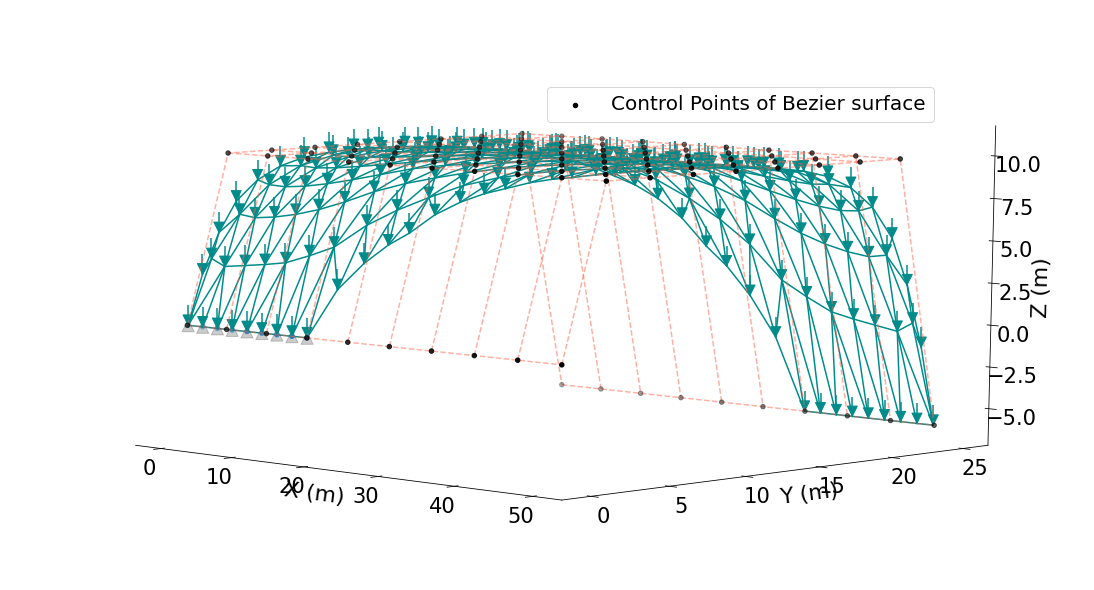

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = Axes3D(fig)
ax.plot_wireframe(Ctrl_pts[:, :, 0], Ctrl_pts[:, :, 1], Ctrl_pts[:, :, 2],linestyle='dashed',color='tomato',alpha=0.5)
ax.scatter(Ctrl_pts[:, :, 0], Ctrl_pts[:, :, 1], Ctrl_pts[:, :, 2],label='Control Points of Bezier surface',color='black')
for i in range(n_ele):
  ax.plot([Bezier_nodes[cnct[i,0],0],Bezier_nodes[cnct[i,1],0]],[Bezier_nodes[cnct[i,0],1],Bezier_nodes[cnct[i,1],1]],[Bezier_nodes[cnct[i,0],2],Bezier_nodes[cnct[i,1],2]],color='darkcyan')
ax.scatter(Bezier_nodes[fixed_nodes,0],Bezier_nodes[fixed_nodes,1],Bezier_nodes[fixed_nodes,2]-0.02,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -45)
ax.scatter(Bezier_nodes[fixed_nodes,0],Bezier_nodes[fixed_nodes,1],Bezier_nodes[fixed_nodes,2])
ax.scatter(Bezier_nodes[:,0],Bezier_nodes[:,1],Bezier_nodes[:,2]+0.6,alpha=1, s=400,marker='|',color='darkcyan')
ax.scatter(Bezier_nodes[:,0],Bezier_nodes[:,1],Bezier_nodes[:,2]+0.32,alpha=1, s=100,marker='v',color='darkcyan')
ax.set_xlabel('X (m)',fontsize=22)
ax.set_ylabel('Y (m)',fontsize=22)
ax.set_zlabel('Z (m)',fontsize=22)
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=21)
ax.tick_params(axis='both', which='minor', labelsize=21)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.legend(fontsize=20,loc=(0.5,0.8))
plt.show()

Properties of the elements

In [ ]:
#Initial coordinate
x_nodes = Bezier_nodes[:,0]
y_nodes = Bezier_nodes[:,1]
z_nodes = Bezier_nodes[:,2]
n_node = Bezier_nodes.shape[0]
#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = 0.1*b*h**3/12 #Moement of inertia in m^4
Iz = 0.1*h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
n_dim = 3 #Dimension of the problem
#Loading
f = np.zeros(n_node*n_dim*2)
load = -100000 #convert to KN
f[design_nodes*6+2] = load #load in z direction

#Convert Ctrl_pts to 2D
Ctrl_pts_2d = Ctrl_pts.reshape(Ctrl_pts.shape[0]*Ctrl_pts.shape[1],Ctrl_pts.shape[2])
n_ctrl_pts = Ctrl_pts_2d.shape[0]
#Configure whether ctrl nodes are unchanged or not
design_ctrl_pts = []
fixed_ctrl_pts = []
for i in range(Ctrl_pts_2d.shape[0]):
  if Ctrl_pts_2d[i,1] == 0 or Ctrl_pts_2d[i,1] == 25:
    fixed_ctrl_pts.append(i)
  else:
    design_ctrl_pts.append(i)

#Convert to np.array
design_ctrl_pts = np.array(design_ctrl_pts)
fixed_ctrl_pts = np.array(fixed_ctrl_pts)

Initial FEA model

In [ ]:
#Build the model
model = pyn.FEModel3D() #model for FEA solving


#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):

  #Adding nodes
  model.add_node("{}".format(i),x_nodes[i],y_nodes[i],z_nodes[i])

  if i in design_nodes:
    model.add_node_load('{}'.format(i),'FZ',load,case='Case 1')
  if i in fixed_nodes:
    model.def_support('{}'.format(i), True, True, True, False, False, False) #Pinned 

#Adding members
for i in range(n_ele):
  i_node = "{}".format(cnct[i,0]) #i-node of beam
  j_node = "{}".format(cnct[i,1]) #j-node of beam
  model.add_member("{}".format(i),i_node,j_node,E,G,Iy,Iz,J,A)

#Add load combo
model.add_load_combo('DEAD',{'Case 1':1})

Initial SSO model

In [ ]:
#Build the model
sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):
  #Adding nodes
  sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])

#Adding elements
for i in range(n_ele):
  i_node = cnct[i,0]
  j_node = cnct[i,1]
  sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A)

# The objective function

JAX-supported version of the Bezier surface.
To get the gradient of the actual structural height wrt Bezier ctrl pts.

In [ ]:
@partial(jit, static_argnums=(5,6,7))
def BezierSurface_z_JAX(params,fixed_ctrl_pts=fixed_ctrl_pts,design_ctrl_pts=design_ctrl_pts,normalized_x=normalized_x,normalized_y=normalized_y,count=normalized_x.shape[0],n_ctrl_pt_u=n_ctrl_pt_u, n_ctrl_pt_v=n_ctrl_pt_v):
    global Ctrl_pts_2d
    Ctrl_pts_z_cons = jnp.zeros(n_ctrl_pt_u*n_ctrl_pt_v) #z coordinate in 1d-array
    Ctrl_pts_z_cons = Ctrl_pts_z_cons.at[fixed_ctrl_pts].set(Ctrl_pts_2d[fixed_ctrl_pts,2]) #update 2d ctrl_pts
    Ctrl_pts_z_cons = Ctrl_pts_z_cons.at[design_ctrl_pts].set(params) #update 2d ctrl_pts
    Ctrl_pts_2d_z_cons = Ctrl_pts_z_cons.reshape(n_ctrl_pt_v,n_ctrl_pt_u)

    pointsU = n_ctrl_pt_u #number of control points along U
    pointsV = n_ctrl_pt_v #number of control points along V
    
    n = n_ctrl_pt_u - 1
    m = n_ctrl_pt_v - 1

    Out = jnp.zeros(count)

    for u in range(count):
      value = 0
      uv_0 = normalized_y[u]
      uv_1 = normalized_x[u]
      for i in range(pointsV):
        for j in range(pointsU):
          value += Ctrl_pts_2d_z_cons[i,j] * BernsteinBasis_mod(m, i, uv_0) * BernsteinBasis_mod(n, j, uv_1)
      Out = Out.at[u].set(value)
    return Out

@jit
def jac_nlcons(params):
  jac_res =jacfwd(BezierSurface_z_JAX)(params)
  return jac_res

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [ ]:
params_store = [] #store parameters
f_store = [] #store the functional value 
sparse = True #Store values in sparse matrix

In [ ]:
def objective(x):
  params_store.append(x) #store params at each step
  current_z = BezierSurface_z_JAX(x) # from ctrl pts to nodal coordinates
  #################
  #Function value#
  #################

  #Update nodes-z
  for i in range(design_nodes.shape[0]):
    model.Nodes[str(design_nodes[i])].Z = current_z[design_nodes[i]] #update params in FEA model
    sens_model.nodes[design_nodes[i]].Z = current_z[design_nodes[i]] #update params in SSO model
  
  #Update elements
  #In FEA model, the element is updated automatically,
  #here we only update SSO model
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) #update elements

  #FEA: solve [K]{u}={f}
  #Get {u}, displacement vector; C=0.5*{f}.T@{u}, compliance(strain energy)
  model.analyze(check_statics=False)
  u = model._D['DEAD'].reshape(-1) #displacement in 1-D vector
  C = 0.5*f@u #compliance of the system
  f_store.append(C) #store the compliance 

  ##################
  #  Gradient  #
  ##################

  #Get the sensitivity using SSO
  sens = np.zeros(Ctrl_pts_2d.shape[0]) #storing the final sensitivity (C to ctrl_pts) -> [n_ctrl] 
  sens_C_to_coord = np.zeros(n_node) #storing sensitivity, [n_node] 
  if sparse:
    sens_K = sens_model.Sens_K_Coord(sparse=True)[:,2] #z-sensitivity for every node
    sens_coord_ele = np.zeros((n_node,n_ctrl_pt_u*n_ctrl_pt_v))
    sens_coord_ele_params = (jacfwd(BezierSurface_z_JAX,argnums=(0,))(x))#[0,:,2,:,2] z-sensitivity, coord to Ctrl_pts
    sens_coord_ele_params = np.array(sens_coord_ele_params)[0]#Get an array of n_node x n_design_ctrl_pts
    sens_coord_ele[:,design_ctrl_pts] = sens_coord_ele_params # Dim conversin
    for k in range(n_node):
      if k in design_nodes:
        sens_C_to_coord[k] = -0.5*u@(sens_K[k].toarray())@u #from stiffness sensitivity to compliance sensitivity
    sens = sens_C_to_coord@sens_coord_ele
  else:
    sens_K = sens_model.Sens_K_Coord(sparse=False)[:,2,:,:] #z-sensitivity
    for k in range(n_node):
      if k!= 0 and k!=n_node-1:
        sens_C_to_coord[k] = -0.5*u@sens_K[k]@u
    sens = sens_C_to_coord@sens_coord_ele
        
  sens_params = sens[design_ctrl_pts] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization: unconstrained

In [ ]:
n_x = design_ctrl_pts.shape[0] #number of parameters
x_ini = Ctrl_pts_2d[design_ctrl_pts,2] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(2e-1) #step size
opt.set_GD_normalized(True) #normalize the gradients
x_opt1 = opt.optimize(x_ini,log=True)

Step 0, objective = 7181976.577836854
Step 1, objective = 6935928.799753685
Step 2, objective = 6695954.687354272
Step 3, objective = 6463106.127652597
Step 4, objective = 6235319.459897117
Step 5, objective = 6010817.382192155
Step 6, objective = 5789410.451134706
Step 7, objective = 5571029.559988789
Step 8, objective = 5355550.664119318
Step 9, objective = 5142726.3034545835
Step 10, objective = 4932585.337381825
Step 11, objective = 4725102.220528733
Step 12, objective = 4520577.04108729
Step 13, objective = 4319215.770041917
Step 14, objective = 4121217.882345871
Step 15, objective = 3926573.0648892093
Step 16, objective = 3735357.7613779865
Step 17, objective = 3547677.882803695
Step 18, objective = 3363730.6841411805
Step 19, objective = 3183893.51411704
Step 20, objective = 3008722.373814601
Step 21, objective = 2838716.838385693
Step 22, objective = 2674492.414840391
Step 23, objective = 2516606.074518635
Step 24, objective = 2365527.5313402805
Step 25, objective = 2221661.181

#Visualization of the final structure

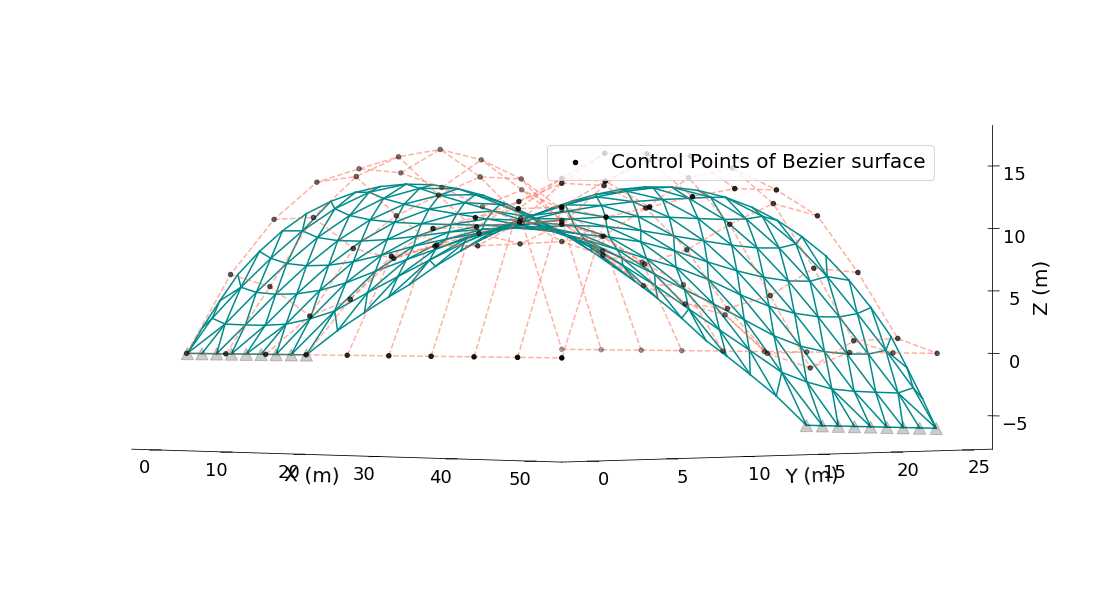

In [ ]:
Bezier_nodes[:,2] = BezierSurface_z_JAX(x_opt1)
Ctrl_pts_z_gd = Ctrl_pts_2d[:,2] #z coordinate in 1d-array
Ctrl_pts_z_gd[design_ctrl_pts]=x_opt1 #update 2d ctrl_pts
Ctrl_pts_2d_z_gd = Ctrl_pts_z_gd.reshape(n_ctrl_pt_u,n_ctrl_pt_v)
fig = plt.figure(figsize=(15,8))
ax = Axes3D(fig)
ax.plot_wireframe(Ctrl_pts[:, :, 0], Ctrl_pts[:, :, 1], Ctrl_pts_2d_z_gd,linestyle='dashed',color='tomato',alpha=0.5)
ax.scatter(Ctrl_pts[:, :, 0], Ctrl_pts[:, :, 1], Ctrl_pts_2d_z_gd,label='Control Points of Bezier surface',color='black')
for i in range(n_ele):
  ax.plot([Bezier_nodes[cnct[i,0],0],Bezier_nodes[cnct[i,1],0]],[Bezier_nodes[cnct[i,0],1],Bezier_nodes[cnct[i,1],1]],[Bezier_nodes[cnct[i,0],2],Bezier_nodes[cnct[i,1],2]],color='darkcyan')
plt.legend(fontsize=20,loc=(0.5,0.7))
ax.scatter(Bezier_nodes[fixed_nodes,0],Bezier_nodes[fixed_nodes,1],Bezier_nodes[fixed_nodes,2]-0.02,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(0, -45)
ax.set_xlabel('X (m)',fontsize=20)
ax.set_ylabel('Y (m)',fontsize=20)
ax.set_zlabel('Z (m)',fontsize=20)

ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.show()